# Domain Adaptation

In [1]:
import sys
sys.path.append('..')
from src.dataset.dataset import (
    build_hsi_testloader,
    build_hsi_dataloader,
    HSIDataset,
    build_FIVES_random_crops_dataloaders,
)
from src.util.constants import FIVES_RANDOM_CROPS_DIR, RING_LABELS_DIR
from torch.utils.data import DataLoader

trainloader_source, validationloader_source, testloader_source = (
    build_FIVES_random_crops_dataloaders(
        batch_size=16,
        num_channels=1,
        load_from_path=FIVES_RANDOM_CROPS_DIR,
    )
)

window = (500, 600)
target_augmented= True
trainloader_target = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    window=window,
    exclude_labeled_data=True,
    augmented=target_augmented,
    ring_label_dir=RING_LABELS_DIR,
)[0]

testloader_target = build_hsi_testloader(
    batch_size=1,
    window=window,
)

print(len(trainloader_target.dataset), len(testloader_target.dataset))

Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200
62 5


## Evaluation of Model without Domain Adaptation on Target Testset

### Transfer Learning

In [6]:
from src.util.segmentation_util import (
    evaluate_model,
    build_segmentation_model,
    load_model,
)
from src.util.constants import MODELS_DIR
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model_path = (
    MODELS_DIR
    / f"Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth"
)
model = build_segmentation_model(
    encoder="timm-regnetx_320",
    architecture="Linknet",
    device=device,
    in_channels=1,
    path=model_path,
)
model.eval()
evaluate_model(model, testloader_target, device, with_wandb=False)

Precision: 0.5460, Recall: 0.2706, F1 Score: 0.3296, Dice Score: 0.3296, Accuracy: 0.8079


(tensor(0.5460, device='cuda:3'),
 tensor(0.2706, device='cuda:3'),
 tensor(0.3296, device='cuda:3'),
 tensor(0.8079, device='cuda:3'),
 tensor(0.3296, device='cuda:3'))

### Ensemble Model

In [7]:
from src.model.HSI_models.HSI_Net import SegmentationModelWithWindowing
from src.util.segmentation_util import build_segmentation_model, evaluate_model
from src.model.HSI_models.ensemble_model import EnsembleModelAverage
import segmentation_models_pytorch as smp
import torch
from src.util.constants import HELICOID_WITH_LABELS_DIR, MODELS_DIR

path = HELICOID_WITH_LABELS_DIR
testset = HSIDataset(path, with_gt=True)
testset.crop_dataset()
testloader_target = DataLoader(testset, batch_size=1, shuffle=False)

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = "cuda:5" if torch.cuda.is_available() else "cpu"

model_path_segmenter = (
    MODELS_DIR
    / f"{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth"
)

segmenter_single_channel = build_segmentation_model(
    encoder, architecture, device, in_channels=1, path=model_path_segmenter
)
segmenter_single_channel.eval()

window1 = (400, 500)
window2 = (500, 600)
window3 = (600, 700)
window4 = (700, 800)
window5 = (800, 900)
window6 = (900, 1000)
window_full = (400, 1100)


model_windowing_400to500 = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window1)
)
model_with_windowing_500to600 = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window2)
)
model_windowing_600to700 = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window3)
)
model_windowing_700to800 = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window4)
)
model_windowing_800to900 = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window5)
)
model_windowing_900to1000 = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window6)
)
model_window_full = SegmentationModelWithWindowing(
    segmenter_single_channel, window=testset.get_window_from_wavelengths(window_full)
)

model = EnsembleModelAverage(
    [
        model_windowing_400to500,
        model_with_windowing_500to600,
        model_windowing_600to700,
        model_windowing_700to800,
        model_windowing_900to1000,
        model_window_full,
    ]
)
evaluate_model(model, testloader_target, device, with_wandb=False)

Precision: 0.5368, Recall: 0.2351, F1 Score: 0.3072, Dice Score: 0.3072, Accuracy: 0.8104


(tensor(0.5368, device='cuda:5'),
 tensor(0.2351, device='cuda:5'),
 tensor(0.3072, device='cuda:5'),
 tensor(0.8104, device='cuda:5'),
 tensor(0.3072, device='cuda:5'))

## Domain Adaptation Approaches:
### GRL domain adaptation

In [ ]:
import matplotlib.pyplot as plt
import torch
from src.training.domain_adaptation_training import model_pipeline
from src.util.constants import MODELS_DIR

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
lambda_param = 0.5
learning_rate = 0.001
loss = "BCE"
epochs = 10
in_channels = 1
hidden_dim = 256
pretrained_path = (
    MODELS_DIR
    / f"Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth"
)

config = {
    "model": "GRL-{architecture}-{encoder}-window_{window[0]}-{window[1]}-pretrained-random_crops-bloodvessel_ratio01".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "lambda_param": lambda_param,
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "hidden_dim": hidden_dim,
    "epochs": epochs,
    "loss": loss,
    "in_channels": in_channels,
    "pretrained": pretrained_path,
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        trainloader_source,
        validationloader_source,
        testloader_source,
        trainloader_target,
        testloader_target,
        config,
        project="domain-adaptation",
        device=device,
        batch_print=10,
        evaluate=True,
        with_overlays=True,
    )
)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descript

Epoch 1, Batch 10/34, Total Loss: 1.8441, Segmentation Loss: 0.4249, Domain Loss Source: 0.6113, Domain Loss Target: 0.6371
Epoch 1, Batch 20/34, Total Loss: 1.7106, Segmentation Loss: 0.3447, Domain Loss Source: 0.5976, Domain Loss Target: 0.9083
Epoch 1, Batch 30/34, Total Loss: 1.7214, Segmentation Loss: 0.3221, Domain Loss Source: 0.7402, Domain Loss Target: 0.8175
Epoch 1, Train Loss: 1.7574
Evaluating model performance on source data
Precision: 0.9107, Recall: 0.3290, F1 Score: 0.4825, Dice Score: 0.4825, Accuracy: 0.8770
Evaluating model performance on target data
Precision: nan, Recall: 0.0748, F1 Score: 0.1181, Dice Score: 0.1181, Accuracy: 0.7753
Epoch 1, Validation Loss Source: 0.2613, Validation Loss Target: 1.4982
Epoch 2, Batch 10/34, Total Loss: 1.8595, Segmentation Loss: 0.2791, Domain Loss Source: 0.7408, Domain Loss Target: 0.9152
Epoch 2, Batch 20/34, Total Loss: 1.7727, Segmentation Loss: 0.2733, Domain Loss Source: 0.6027, Domain Loss Target: 0.9855
Epoch 2, Batch 

### FADA:

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200
Loading pretrained model from /mnt/Drive3/tim/bloodvessel_segmentation_models/models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth
Using Feature Extractor with Convolutional Reducer: 1x1conv
Initializing Cycle Loss Setup


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 5/34, Total Loss: 1.1364, Segmentation Loss: 0.4534, Domain Loss Source: 0.3055, Domain Loss Target: 0.3187, Adversarial Loss Target: 0.0006
Epoch 1, Batch 10/34, Total Loss: 1.0549, Segmentation Loss: 0.4070, Domain Loss Source: 0.3070, Domain Loss Target: 0.3188, Adversarial Loss Target: 0.0006
Epoch 1, Batch 15/34, Total Loss: 1.0140, Segmentation Loss: 0.4140, Domain Loss Source: 0.3562, Domain Loss Target: 0.2317, Adversarial Loss Target: 0.0009
Epoch 1, Batch 20/34, Total Loss: 0.9838, Segmentation Loss: 0.3663, Domain Loss Source: 0.2126, Domain Loss Target: 0.3604, Adversarial Loss Target: 0.0006
Epoch 1, Batch 25/34, Total Loss: 0.9551, Segmentation Loss: 0.3340, Domain Loss Source: 0.3045, Domain Loss Target: 0.2881, Adversarial Loss Target: 0.0007
Epoch 1, Batch 30/34, Total Loss: 0.9064, Segmentation Loss: 0.3155, Domain Loss Source: 0.2549, Domain Loss Target: 0.3016, Adversarial Loss Target: 0.0008
Epoch 1, Train Loss: 2.9362
Evaluating model performance on

dice_score/source,▁
dice_score/target,▁
dice_score/target_postprocessed,▁
epoch,▁
precision/source,▁
precision/target,▁
precision/target_postprocessed,▁
test/accuracy,▁
test/accuracy_postprocessed,▁
test/cl_dice_score_postprocessed,▁
test/dice_score,▁


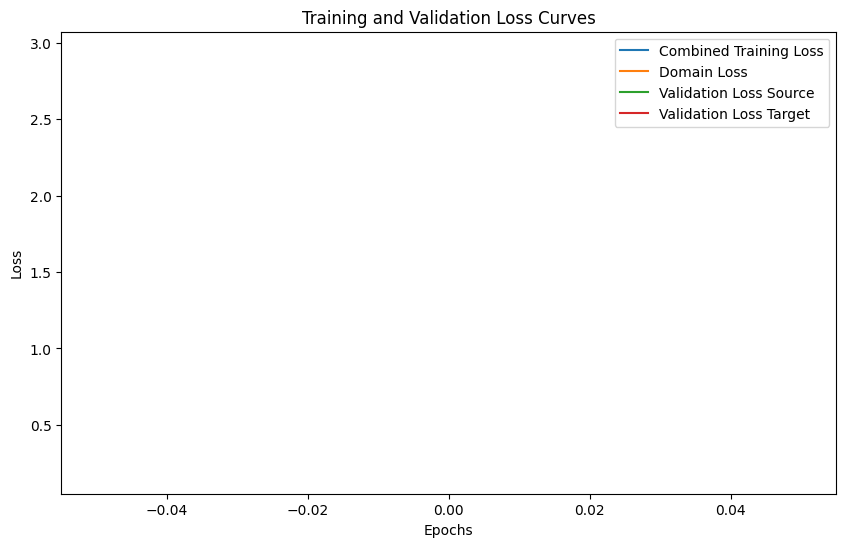

In [2]:
import matplotlib.pyplot as plt
from src.training.train_FADA_unsupervised import model_pipeline
from src.util.constants import MODELS_DIR, FIVES_RANDOM_CROPS_DIR
import torch

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_path = (
    MODELS_DIR
    / f"Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth"
)
dataset_path = FIVES_RANDOM_CROPS_DIR

config = {
    "model": "FADA-With-FeatureConvReducer-1x1Conv",
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": 1,
    "optimizer": "Adam",
    "batch_size_source": 16,
    "batch_size_target": 8,
    "learning_rate_fea": 0.001,
    "learning_rate_cls": 0.001,
    "learning_rate_dis": 0.0001,
    "ndf": 512,
    "epochs": 1,
    "seg_loss": "BCE",
    "pretrained": pretrained_path,
    "augmented": True,
    "dataset_path": dataset_path,
    "feature_conv_reducer": "1x1conv",
    "cycle_loss_hyperparams": {
        "lr_F": 0.001,
        "lr_G": 0.001,
        "lambda_F": 0.5,
        "lambda_G": 0.5,
    },
}


model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        config,
        project="domain-adaptation",
        device=device,
        batch_print=5,
        evaluate=True,
        with_overlays=True,
        save_wandb=False,
        save_path="models/FeatureConvReducer",
    )
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

### Supervised Domain Adapatation

#### GRL

In [ ]:
from torch.utils.data import DataLoader, Subset
import torch
from src.training.supervised_domain_adaptation import model_pipeline

trainloader_target_labeled = DataLoader(
    Subset(testset, [0]),
    batch_size=1,
    shuffle=True,
)
testloader_target = DataLoader(
    Subset(testset, [1, 2, 3, 4]), batch_size=1, shuffle=False
)

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
lambda_param = 0.5
learning_rate = 0.001
loss = "Dice"
epochs = 10
in_channels = 1
hidden_dim = 256

config = {
    "model": "GRL-{architecture}-{encoder}-window_{window[0]}-{window[1]}-pretrained-random_crops-bloodvessel_ratio01-supervised".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "lambda_param": lambda_param,
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "hidden_dim": hidden_dim,
    "epochs": epochs,
    "loss": loss,
    "in_channels": in_channels,
    "pretrained": './models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth',
    "supervised": True,
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target_labeled,
    trainloader_target,
    testloader_target,
    config,
    project="supervised-domain-adaptation",
    device=device,
    batch_print=1,
    evaluate=True,
    with_overlays=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 1/34, Total Loss: 2.1479, Segmentation Loss: 0.7283, Domain Loss Source: 0.7582, Domain Loss Target: 0.6614
Epoch 1, Batch 2/34, Total Loss: 30.4464, Segmentation Loss: 0.6874, Domain Loss Source: 0.0000, Domain Loss Target: 29.7590
Epoch 1, Batch 3/34, Total Loss: 45.6899, Segmentation Loss: 0.6732, Domain Loss Source: 43.6820, Domain Loss Target: 1.3348
Epoch 1, Batch 4/34, Total Loss: 60.7336, Segmentation Loss: 0.6997, Domain Loss Source: 58.5175, Domain Loss Target: 1.5164
Epoch 1, Batch 5/34, Total Loss: 19.6700, Segmentation Loss: 0.6691, Domain Loss Source: 15.5772, Domain Loss Target: 3.4236
Epoch 1, Batch 6/34, Total Loss: 23.4743, Segmentation Loss: 0.7398, Domain Loss Source: 16.1773, Domain Loss Target: 6.5572
Epoch 1, Batch 7/34, Total Loss: 39.3069, Segmentation Loss: 0.6454, Domain Loss Source: 0.7192, Domain Loss Target: 37.9422


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Batch 8/34, Total Loss: 31.2116, Segmentation Loss: 0.7010, Domain Loss Source: 11.5278, Domain Loss Target: 18.9828
Epoch 1, Batch 9/34, Total Loss: 6.9516, Segmentation Loss: 0.6254, Domain Loss Source: 5.3976, Domain Loss Target: 0.9286
Epoch 1, Batch 10/34, Total Loss: 3.5846, Segmentation Loss: 0.6483, Domain Loss Source: 0.1458, Domain Loss Target: 2.7905
Epoch 1, Batch 11/34, Total Loss: 10.3006, Segmentation Loss: 0.6348, Domain Loss Source: 2.2692, Domain Loss Target: 7.3966
Epoch 1, Batch 12/34, Total Loss: 9.2024, Segmentation Loss: 0.6809, Domain Loss Source: 1.9968, Domain Loss Target: 6.5247
Epoch 1, Batch 13/34, Total Loss: 4.0135, Segmentation Loss: 0.6346, Domain Loss Source: 3.1238, Domain Loss Target: 0.2550
Epoch 1, Batch 14/34, Total Loss: 19.5268, Segmentation Loss: 0.6613, Domain Loss Source: 6.5280, Domain Loss Target: 12.3374
Epoch 1, Batch 15/34, Total Loss: 2.5017, Segmentation Loss: 0.6154, Domain Loss Source: 1.8577, Domain Loss Target: 0.0286
Epoc

#### FADA

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 10/34, Total Loss: 1.0578, Segmentation Loss: 0.4373, Domain Loss Source: 0.3387, Domain Loss Target: 0.2318, Adversarial Loss Target: 0.0009
Epoch 1, Batch 20/34, Total Loss: 0.9842, Segmentation Loss: 0.3694, Domain Loss Source: 0.3450, Domain Loss Target: 0.2909, Adversarial Loss Target: 0.0012
Epoch 1, Batch 30/34, Total Loss: 0.8321, Segmentation Loss: 0.3126, Domain Loss Source: 0.2059, Domain Loss Target: 0.2563, Adversarial Loss Target: 0.0010
Epoch 1, Train Loss: 4.9357


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating model performance on source data
Precision: 0.9679, Recall: 0.2987, F1 Score: 0.4549, Dice Score: 0.4549, Accuracy: 0.8754
Evaluating model performance on target data
Precision: nan, Recall: 0.1847, F1 Score: 0.2401, Dice Score: 0.2401, Accuracy: 0.7989
Epoch 1, Validation Loss Source: 0.2642, Validation Loss Target: 0.6929
Epoch 2, Batch 10/34, Total Loss: 0.7133, Segmentation Loss: 0.2836, Domain Loss Source: 0.2742, Domain Loss Target: 0.1458, Adversarial Loss Target: 0.0018
Epoch 2, Batch 20/34, Total Loss: 0.7254, Segmentation Loss: 0.2543, Domain Loss Source: 0.2818, Domain Loss Target: 0.1544, Adversarial Loss Target: 0.0020
Epoch 2, Batch 30/34, Total Loss: 0.6715, Segmentation Loss: 0.2273, Domain Loss Source: 0.3369, Domain Loss Target: 0.1476, Adversarial Loss Target: 0.0018
Epoch 2, Train Loss: 3.5858
Evaluating model performance on source data
Precision: 0.9597, Recall: 0.4010, F1 Score: 0.5633, Dice Score: 0.5633, Accuracy: 0.8920
Evaluating model performance o

dice_score/source,▁▅▇▇█████▇
dice_score/target,▁▃▇███████
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,█▇▅▄▃▂▂▁▂▂
precision/target,▁██▇▇█▇▇█
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,█▃▅▄▅▃▃▄▃▁


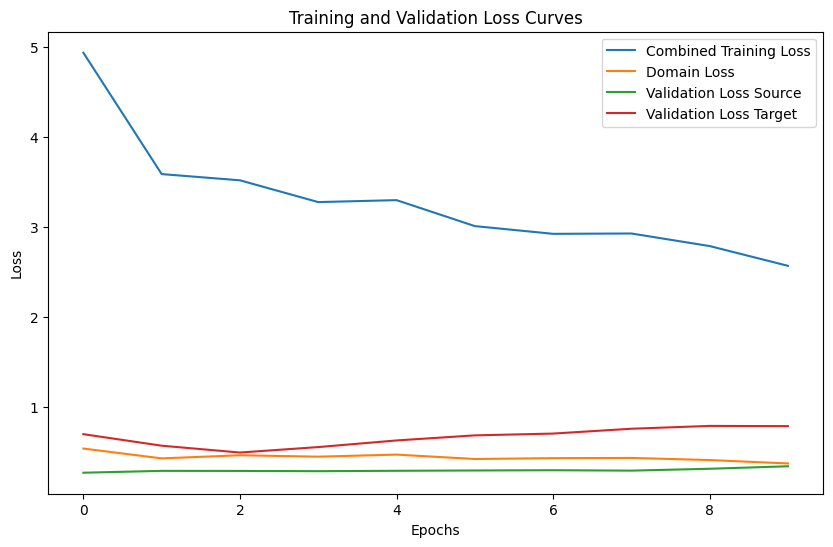

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from src.training.train_FADA_supervised import model_pipeline

train_indices = [0]
trainloader_target_labeled = DataLoader(
    Subset(testset, train_indices),
    batch_size=1,
    shuffle=True,
)
testloader_target = DataLoader(
    Subset(testset, list({0, 1, 2, 3, 4} - set(train_indices))),
    batch_size=1,
    shuffle=False,
)

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
epochs = 10
loss = "BCE"
in_channels = 1
ndf = 512
learning_rate_fea = 0.001
learning_rate_cls = 0.001
learning_rate_dis = 0.0001

config = {
    "model": "FADA-{architecture}-{encoder}-window_{window[0]}-{window[1]}_pretrained-augmented_target-random_crops_bloodvessel_ratio01".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "ndf": ndf,
    "epochs": epochs,
    "seg_loss": loss,
    "pretrained": "./models/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth",
    "target_augmented": target_augmented,
    "train_indices": train_indices,
}


model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        trainloader_source,
        validationloader_source,
        testloader_source,
        trainloader_target_labeled,
        trainloader_target,
        testloader_target,
        config,
        project="supervised-domain-adaptation",
        device=device,
        batch_print=10,
        evaluate=True,
        with_overlays=True,
    )
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

### Gaussian Autoencoder

#### Training

In [ ]:
from dataset import build_hsi_dataloader, HSIDataset, build_hsi_testloader
from src.training.train_autoencoder import model_pipeline_autoencoder
import torch

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
config = {
    "model": "gcr-comic-sweep-trained-longer",
    "optimizer": "Adam",
    "lr_encoder": 0.003991856255637263,
    "lr_decoder": 0.0001405199848490131,
    "batch_size": 4,
    "epochs": 25,
    "mu": [335, 267, 131],
    "sigma": [1, 1, 1],
}

model_pipeline_autoencoder(
    config,
    project="hsi-autoencoder",
    epochs=25,
    device=device,
    batch_print=5,
    save_wandb=False
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Epoch 1, Batch 5, Loss: 0.2909
Epoch 1, Batch 10, Loss: 0.2733
Epoch 1, Batch 15, Loss: 0.2472
Epoch 1, Train Loss: 0.2650
Precision: 0.4655, Recall: 0.4525, F1 Score: 0.4482, Dice Score: 0.4482, Accuracy: 0.7844
Epoch 1, Validation Loss: 0.5848
Epoch 2, Batch 5, Loss: 0.2467
Epoch 2, Batch 10, Loss: 0.2359
Epoch 2, Batch 15, Loss: 0.2991
Epoch 2, Train Loss: 0.2607
Precision: 0.4654, Recall: 0.4529, F1 Score: 0.4484, Dice Score: 0.4484, Accuracy: 0.7843
Epoch 2, Validation Loss: 0.5796
Epoch 3, Batch 5, Loss: 0.2650
Epoch 3, Batch 10, Loss: 0.2774
Epoch 3, Batch 15, Loss: 0.2412
Epoch 3, Train Loss: 0.2622
Precision: 0.4653, Recall: 0.4533, F1 Score: 0.4486, Dice Score: 0.4486, Accuracy: 0.7843
Epoch 3, Validation Loss: 0.5740
Epoch 4, Batch 5, Loss: 0.2247
Epoch 4, Batch 10, Loss: 0.2669
Epoch 4, Batch 15, Loss: 0.2823
Epoch 4, Train Loss: 0.2642
Precision: 0.4651, Recall: 0.4537, F1 Score: 0.4487, Dice Score: 0.4487, Accuracy: 0.7842
Epoch 4, Validation Loss: 0.5687
Epoch 5, Batch 5

dice_score,▆▆▇█▇▇▇▇▇▇▇▇▇▇████▇▆▆▅▄▂▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
precision,██▇▇▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁
train/loss,█▇██▇▇▇▆▆▅▆▅▅▄▅▄▄▃▄▂▃▃▂▁▁
validation/loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
dice_score,0.44666
epoch,25
precision,0.46247
train/loss,0.20998
validation/loss,0.46807


(GaussianAutoEncoder(
   (encoder): GaussianChannelReduction()
   (decoder): Sequential(
     (0): Conv2d(3, 826, kernel_size=(1, 1), stride=(1, 1))
   )
 ),
 [0.26498704589903355,
  0.26065779477357864,
  0.26216429099440575,
  0.2642474053427577,
  0.25316854286938906,
  0.2541518956422806,
  0.25495866034179926,
  0.25081960670650005,
  0.24636503402143717,
  0.24360113125294447,
  0.24611327424645424,
  0.23962208162993193,
  0.23826881125569344,
  0.2349787252023816,
  0.2370747309178114,
  0.22864695638418198,
  0.23393349163234234,
  0.22605776879936457,
  0.22936534835025668,
  0.2180381240323186,
  0.22055898141115904,
  0.2216031150892377,
  0.21681103017181158,
  0.20754558499902487,
  0.2099823895841837],
 [0.584813916683197,
  0.5795517534017562,
  0.5740000367164612,
  0.5687262386083602,
  0.56311194896698,
  0.5579179108142853,
  0.5527239143848419,
  0.5474654883146286,
  0.5425585150718689,
  0.5375813484191895,
  0.5325294882059097,
  0.5274864673614502,
  0.52268925

#### Gaussian reduction + DA

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200


wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Loading pretrained model from ./models/serene-sweep-9.pth
Using Gaussian Channel Reduction


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Batch 5/34, Total Loss: 4.9166, Segmentation Loss: 0.2590, Domain Loss Source: 0.0000, Domain Loss Target: 9.0312, Adversarial Loss Target: 0.0000
Epoch 1, Batch 10/34, Total Loss: 1.7854, Segmentation Loss: 0.2620, Domain Loss Source: 0.2797, Domain Loss Target: 0.3624, Adversarial Loss Target: 0.0006
Epoch 1, Batch 15/34, Total Loss: 1.1583, Segmentation Loss: 0.2092, Domain Loss Source: 0.7618, Domain Loss Target: 0.1001, Adversarial Loss Target: 0.0016
Epoch 1, Batch 20/34, Total Loss: 0.9656, Segmentation Loss: 0.2295, Domain Loss Source: 0.1748, Domain Loss Target: 0.5135, Adversarial Loss Target: 0.0004
Epoch 1, Batch 25/34, Total Loss: 0.8674, Segmentation Loss: 0.1388, Domain Loss Source: 0.1911, Domain Loss Target: 0.4740, Adversarial Loss Target: 0.0004
Epoch 1, Batch 30/34, Total Loss: 0.8252, Segmentation Loss: 0.1460, Domain Loss Source: 0.4454, Domain Loss Target: 0.2020, Adversarial Loss Target: 0.0009
Epoch 1, Train Loss: 4.7005


/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating model performance on source data
Precision: 0.9181, Recall: 0.5615, F1 Score: 0.6948, Dice Score: 0.6948, Accuracy: 0.9147
Evaluating model performance on target data
Precision: 0.5151, Recall: 0.5436, F1 Score: 0.5246, Dice Score: 0.5246, Accuracy: 0.8072
Epoch 1, Validation Loss Source: 0.2797, Validation Loss Target: 0.8326
Epoch 2, Batch 5/34, Total Loss: 0.7925, Segmentation Loss: 0.2047, Domain Loss Source: 0.2247, Domain Loss Target: 0.3877, Adversarial Loss Target: 0.0005
Epoch 2, Batch 10/34, Total Loss: 0.7661, Segmentation Loss: 0.1439, Domain Loss Source: 0.3419, Domain Loss Target: 0.2884, Adversarial Loss Target: 0.0007
Epoch 2, Batch 15/34, Total Loss: 0.7512, Segmentation Loss: 0.1254, Domain Loss Source: 0.3471, Domain Loss Target: 0.2665, Adversarial Loss Target: 0.0007
Epoch 2, Batch 20/34, Total Loss: 0.7387, Segmentation Loss: 0.1365, Domain Loss Source: 0.3221, Domain Loss Target: 0.2717, Adversarial Loss Target: 0.0007
Epoch 2, Batch 25/34, Total Loss:

dice_score/source,▁▅▆▇▆▇▇▇██
dice_score/target,▁▃▅▆▇▇▇▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,█▂▃▃▃▃▃▃▁▁
precision/target,█▄▄▃▄▂▂▂▁▂
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/domain_loss,█▂▁▁▁▁▁▁▁▁


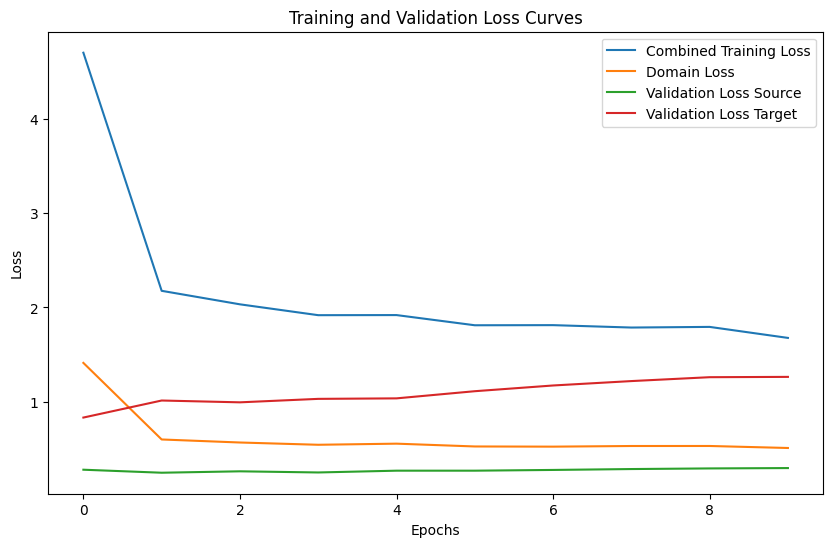

In [ ]:
import matplotlib.pyplot as plt
from src.training.train_FADA_unsupervised import model_pipeline
import torch
from src.dataset.dataset import build_hsi_dataloader, build_hsi_testloader, build_FIVES_random_crops_dataloaders

trainloader_source, validationloader_source, testloader_source = (
    build_FIVES_random_crops_dataloaders(
        batch_size=16,
        num_channels=3,
        load_from_path='data/FIVES_random_crops_threshold01'
    )
)

trainloader_hsi = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    exclude_labeled_data=True,
    augmented=True,
)[0]

testloader_hsi = build_hsi_testloader()

encoder = "timm-regnetx_320"
architecture = "Linknet"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
epochs = 10
loss = "BCE"
in_channels = 3
ndf = 512
learning_rate_fea = 0.007053148664641283
learning_rate_cls = 0.0014884108364363155
learning_rate_dis = 0.00043925067706149473

config = {
    "model": "FADA-{architecture}-{encoder}-gcr_comic-sweep_pretrained-augmented_target-random_crops_bloodvessel_ratio01-unsupervised".format(
        architecture=architecture, encoder=encoder
    ),
    "encoder": encoder,
    "architecture": architecture,
    "in_channels": in_channels,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_hsi.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "ndf": ndf,
    "epochs": epochs,
    "seg_loss": loss,
    "pretrained": "./models/serene-sweep-9.pth",
    "target_augmented": True,
    "gaussian": 'models/gcr_comic-sweep.pth',
    "mu_gaussian": [334.19, 266.26, 131.40],
    "sigma_gaussian": [2.92, 2.02, 2.00],
}

model, train_losses, domain_losses, val_losses_source, val_losses_target = (
    model_pipeline(
        trainloader_source,
        validationloader_source,
        testloader_source,
        trainloader_hsi,
        testloader_hsi,
        config,
        project="domain-adaptation",
        device=device,
        batch_print=5,
        evaluate=True,
        with_overlays=True,
    )
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(domain_losses, label="Domain Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

### Conv Autoencoder

#### Training

In [ ]:
from dataset import build_hsi_dataloader, HSIDataset, build_hsi_testloader
from src.model.dimensionality_reduction.autoencoder import (
    ConvAutoEncoder,
)
from src.training.train_autoencoder import model_pipeline_autoencoder
import torch
from torch.utils.data import DataLoader

trainloader_hsi = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    exclude_labeled_data=True,
    augmented=True,
)[0]

testloader_hsi = build_hsi_testloader()

lr = 0.001
gaussian = ConvAutoEncoder()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gaussian.parameters(), lr=lr)


config = {
    "model": "convReducer",
    "optimizer": "Adam",
    "learning_rate": lr,
    "batch_size": trainloader_hsi.batch_size,
    "epochs": 10,
}

model_pipeline_autoencoder(
    gaussian,
    trainloader_hsi,
    testloader_hsi,
    criterion,
    optimizer,
    config,
    project="hsi-autoencoder",
    device=device,
    model_name="convReducer",
    batch_print=5,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Epoch 1, Batch 5, Loss: 0.3534
Epoch 1, Train Loss: 0.3321
Epoch 1, Validation Loss: 0.5521
Epoch 2, Batch 5, Loss: 68.4464
Epoch 2, Train Loss: 38.1581
Epoch 2, Validation Loss: 0.5897
Epoch 3, Batch 5, Loss: 0.2826
Epoch 3, Train Loss: 0.3083
Epoch 3, Validation Loss: 0.5497
Epoch 4, Batch 5, Loss: 9.5290
Epoch 4, Train Loss: 5.4296
Epoch 4, Validation Loss: 0.5457
Epoch 5, Batch 5, Loss: 2.1078
Epoch 5, Train Loss: 1.2938
Epoch 5, Validation Loss: 0.5238
Epoch 6, Batch 5, Loss: 0.2620
Epoch 6, Train Loss: 0.2701
Epoch 6, Validation Loss: 0.5040
Epoch 7, Batch 5, Loss: 0.2863
Epoch 7, Train Loss: 0.2679
Epoch 7, Validation Loss: 0.4993
Epoch 8, Batch 5, Loss: 56.5798
Epoch 8, Train Loss: 31.5554
Epoch 8, Validation Loss: 0.6629
Epoch 9, Batch 5, Loss: 0.3270
Epoch 9, Train Loss: 0.3380
Epoch 9, Validation Loss: 0.6395
Epoch 10, Batch 5, Loss: 0.2751
Epoch 10, Train Loss: 0.2847
Epoch 10, Validation Loss: 0.5216


epoch,▁▂▃▃▄▅▆▆▇█
train/loss,▁█▁▂▁▁▁▇▁▁
validation/loss,▃▅▃▃▂▁▁█▇▂
epoch,10
train/loss,0.28467
validation/loss,0.52159


(ConvAutoEncoder(
   (encoder): ConvReducer(
     (conv1x1): Conv2d(826, 3, kernel_size=(1, 1), stride=(1, 1))
   )
   (decoder): Sequential(
     (0): Conv2d(3, 826, kernel_size=(1, 1), stride=(1, 1))
   )
 ),
 [0.33212346500820583,
  38.15814441608058,
  0.3083326352967156,
  5.429602690868908,
  1.2937968108389113,
  0.27008532815509373,
  0.26786717110209995,
  31.555382001731132,
  0.33804674943288165,
  0.2846721609433492],
 [0.5520845353603363,
  0.5896639406681061,
  0.5497033417224884,
  0.5457060217857361,
  0.5238021850585938,
  0.5040395379066467,
  0.49933808743953706,
  0.6628828555345535,
  0.6394935458898544,
  0.5215946286916733])

## Evaluation

In [ ]:
from src.dataset.dataset import build_hsi_testloader
from src.util.segmentation_util import (
    build_segmentation_model,
    show_interactive_overlay,
)
from src.util.constants import RING_LABELS_DIR, MODELS_DIR
import torch

testloader_target, testloader_ring_label = build_hsi_testloader(
    window=(500, 600),
    batch_size=1,
    ring_label_dir=RING_LABELS_DIR,
)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_path = (
    MODELS_DIR
    / "Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth"
)
model = build_segmentation_model(
    "timm-regnetx_320", "Linknet", device, in_channels=1, path=model_path
)
# model = build_FADA_segmentation_model(
#     architecture="Linknet",
#     encoder="timm-regnetx_320",
#     device=device,
#     in_channels=3,
#     path="models/FADA-Linknet-timm-regnetx_320-gcr_comic-sweep_pretrained-augmented_target-random_crops_bloodvessel_ratio01-unsupervised.pth",
#     channel_reducer_path="models/gcr_comic-sweep.pth",
# )

index = 0
show_interactive_overlay(
    model,
    data=testloader_target.dataset[index],
    device=device,
    title="test",
    ring_data=testloader_ring_label.dataset[index][1],
)
# evaluate_model_with_postprocessing(
#     model, testloader_target, testloader_ring_label, device, with_wandb=False
# )

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='test',…

### Approach 1: FADA-Grayscale-Windowing

In [2]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import build_FADA_segmentation_model
from src.util.constants import MODELS_DIR

model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach1"),
    window=(500, 600),
    device="cuda:1",
    build_func=build_FADA_segmentation_model,
    model_params=model_params,
)

Testing model /mnt/Drive3/tim/bloodvessel_segmentation_models/models/approach1/image0/misty-sweep-3.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.5352, Recall: 0.6670, F1 Score: 0.5910, Dice Score: 0.5910, CL Dice Score: 0.5533, Accuracy: 0.8196
Testing model /mnt/Drive3/tim/bloodvessel_segmentation_models/models/approach1/image1/fanciful-sweep-4.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.5303, Recall: 0.7830, F1 Score: 0.6316, Dice Score: 0.6316, CL Dice Score: 0.5946, Accuracy: 0.7854
Testing model /mnt/Drive3/tim/bloodvessel_segmentation_models/models/approach1/image2/golden-sweep-3.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.5292, Recall: 0.6412, F1 Score: 0.5739, Dice Score: 0.5739, CL Dice Score: 0.5309, Accuracy: 0.8251
Testing model /mnt/Drive3/tim/bloodvessel_segmentation_models/models/approach1/image3/fallen-sweep-2.pth hyperparameter-finetuned on image 3 tes

(tensor(0.5338, device='cuda:1'),
 tensor(0.6646, device='cuda:1'),
 tensor(0.8158, device='cuda:1'),
 tensor(0.5833, device='cuda:1'),
 0.505410452513938)

### Approach 2: FADA-Grayscale-Windowing-NoPretraining

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import build_FADA_segmentation_model
from src.util.constants import MODELS_DIR

model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach2"),
    window=(500, 600),
    device="cuda:1",
    build_func=build_FADA_segmentation_model,
    model_params=model_params,
)

Testing model models/approach2/image0/exalted-sweep-1.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.5215, Recall: 0.3836, F1 Score: 0.4391, Dice Score: 0.4391, CL Dice Score: 0.3675, Accuracy: 0.8105
Testing model models/approach2/image1/wandering-sweep-6.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.5370, Recall: 0.6201, F1 Score: 0.5739, Dice Score: 0.5739, CL Dice Score: 0.5359, Accuracy: 0.7871
Testing model models/approach2/image2/hearty-sweep-1.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.5145, Recall: 0.4671, F1 Score: 0.4838, Dice Score: 0.4838, CL Dice Score: 0.4206, Accuracy: 0.8076
Testing model models/approach2/image3/easy-sweep-9.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.4186, Recall: 0.6554, F1 Score: 0.5100, Dice Score: 0.5100, CL Dice Score: 0.4902, Accuracy: 0.7725
Testing model models/approach2/image4/eternal-swee

(tensor(0.4886, device='cuda:1'),
 tensor(0.5370, device='cuda:1'),
 tensor(0.7928, device='cuda:1'),
 tensor(0.5006, device='cuda:1'),
 0.4296932337571002)

### Approach 3: FADA-3ChannelWindowing

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import build_FADA_segmentation_model
from src.util.constants import MODELS_DIR

model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 3,
    "windows_in_nm": [[600, 1000], [500, 600], [400, 500]],
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach3"),
    build_func=build_FADA_segmentation_model,
    device="cuda:1",
    model_params=model_params,
)

Testing model models/approach3/image0/sandy-sweep-1.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.5057, Recall: 0.7008, F1 Score: 0.5851, Dice Score: 0.5851, CL Dice Score: 0.5838, Accuracy: 0.8076
Testing model models/approach3/image1/generous-sweep-2.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.5496, Recall: 0.6445, F1 Score: 0.5901, Dice Score: 0.5901, CL Dice Score: 0.5533, Accuracy: 0.7969
Testing model models/approach3/image2/woven-sweep-8.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.4882, Recall: 0.6959, F1 Score: 0.5640, Dice Score: 0.5640, CL Dice Score: 0.5577, Accuracy: 0.7975
Testing model models/approach3/image3/glad-sweep-3.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.4675, Recall: 0.5350, F1 Score: 0.4882, Dice Score: 0.4882, CL Dice Score: 0.4738, Accuracy: 0.8040
Testing model models/approach3/image4/classic-sweep-5.

(tensor(0.4981, device='cuda:1'),
 tensor(0.6312, device='cuda:1'),
 tensor(0.8013, device='cuda:1'),
 tensor(0.5489, device='cuda:1'),
 0.504208641369838)

### Approach 4: FADA-Grayscale-Windowing-400_500

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import build_FADA_segmentation_model
from src.util.constants import MODELS_DIR


model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach4"),
    window=(400, 500),
    device="cuda:1",
    build_func=build_FADA_segmentation_model,
    model_params=model_params,
)

Testing model models/approach4/image0/rose-sweep-9.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.4900, Recall: 0.4502, F1 Score: 0.4587, Dice Score: 0.4587, CL Dice Score: 0.4030, Accuracy: 0.8090
Testing model models/approach4/image1/faithful-sweep-10.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.6636, Recall: 0.5839, F1 Score: 0.6185, Dice Score: 0.6185, CL Dice Score: 0.5100, Accuracy: 0.8303
Testing model models/approach4/image2/brisk-sweep-6.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.5159, Recall: 0.7684, F1 Score: 0.6044, Dice Score: 0.6044, CL Dice Score: 0.5479, Accuracy: 0.8017
Testing model models/approach4/image3/celestial-sweep-3.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.5130, Recall: 0.6696, F1 Score: 0.5690, Dice Score: 0.5690, CL Dice Score: 0.4701, Accuracy: 0.8173
Testing model models/approach4/image4/upbeat-swee

(tensor(0.5481, device='cuda:1'),
 tensor(0.5932, device='cuda:1'),
 tensor(0.8170, device='cuda:1'),
 tensor(0.5513, device='cuda:1'),
 0.4350944207147376)

### Approach 5: FADA-Grayscale-Windowing-600_800

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import build_FADA_segmentation_model
from src.util.constants import MODELS_DIR


model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach5"),
    window=(600, 800),
    device="cuda:1",
    build_func=build_FADA_segmentation_model,
    model_params=model_params,
)

Testing model models/approach5/image0/fearless-sweep-9.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.6166, Recall: 0.5479, F1 Score: 0.5725, Dice Score: 0.5725, CL Dice Score: 0.4437, Accuracy: 0.8410
Testing model models/approach5/image1/pleasant-sweep-8.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.6738, Recall: 0.6101, F1 Score: 0.6325, Dice Score: 0.6325, CL Dice Score: 0.4865, Accuracy: 0.8346
Testing model models/approach5/image2/true-sweep-1.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.5898, Recall: 0.6921, F1 Score: 0.6357, Dice Score: 0.6357, CL Dice Score: 0.5393, Accuracy: 0.8463
Testing model models/approach5/image3/atomic-sweep-10.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.5557, Recall: 0.6573, F1 Score: 0.6011, Dice Score: 0.6011, CL Dice Score: 0.4991, Accuracy: 0.8414
Testing model models/approach5/image4/lunar-sweep

(tensor(0.6116, device='cuda:1'),
 tensor(0.5972, device='cuda:1'),
 tensor(0.8405, device='cuda:1'),
 tensor(0.5947, device='cuda:1'),
 0.3968475897298889)

### Approach 6: Ensemble Model

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths, build_ensemble_model
from src.util.constants import MODELS_DIR

model_params = {}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach6"),
    device="cuda:1",
    build_func=build_ensemble_model,
    model_params=model_params,
)


Testing model models/approach6/image0/ensemble.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.5827, Recall: 0.3645, F1 Score: 0.4380, Dice Score: 0.4380, CL Dice Score: 0.3688, Accuracy: 0.8192
Testing model models/approach6/image1/ensemble.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.7914, Recall: 0.4309, F1 Score: 0.5500, Dice Score: 0.5500, CL Dice Score: 0.3970, Accuracy: 0.8380
Testing model models/approach6/image2/ensemble.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.7020, Recall: 0.3966, F1 Score: 0.5029, Dice Score: 0.5029, CL Dice Score: 0.3776, Accuracy: 0.8408
Testing model models/approach6/image3/ensemble.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.6902, Recall: 0.4428, F1 Score: 0.5340, Dice Score: 0.5340, CL Dice Score: 0.3941, Accuracy: 0.8612
Testing model models/approach6/image4/ensemble.pth hyperparameter-finetuned 

(tensor(0.6906, device='cuda:1'),
 tensor(0.4067, device='cuda:1'),
 tensor(0.8416, device='cuda:1'),
 tensor(0.5041, device='cuda:1'),
 0.34885934637632876)

### Approach 7: FADA-Grayscale with CL Dice

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import build_FADA_segmentation_model
from src.util.constants import MODELS_DIR


model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach7"),
    window=(500, 600),
    device="cuda:0",
    build_func=build_FADA_segmentation_model,
    model_params=model_params,
)

Testing model models/approach7/image0/volcanic-sweep-13.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.4815, Recall: 0.6294, F1 Score: 0.5438, Dice Score: 0.5438, CL Dice Score: 0.5585, Accuracy: 0.7948
Testing model models/approach7/image1/vague-sweep-4.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.4655, Recall: 0.7588, F1 Score: 0.5746, Dice Score: 0.5746, CL Dice Score: 0.6051, Accuracy: 0.7363
Testing model models/approach7/image2/stellar-sweep-3.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.4996, Recall: 0.6755, F1 Score: 0.5114, Dice Score: 0.5114, CL Dice Score: 0.5233, Accuracy: 0.7841
Testing model models/approach7/image3/gentle-sweep-4.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]


/home/home/tim_ivan/idp/metrics/cldice.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(v * s) / np.sum(s)


Precision: nan, Recall: 0.2905, F1 Score: 0.3079, Dice Score: 0.3079, CL Dice Score: nan, Accuracy: 0.7928
Testing model models/approach7/image4/elated-sweep-10.pth hyperparameter-finetuned on image 4 testing on images [0, 1, 2, 3]
Precision: 0.4554, Recall: 0.6907, F1 Score: 0.5480, Dice Score: 0.5480, CL Dice Score: 0.5571, Accuracy: 0.7845
Average Precision: nan, Average Recall: 0.6090, Average Accuracy: 0.7785, Average Dice Score: 0.4971, Average CL Dice Score: nan


(tensor(nan, device='cuda:0'),
 tensor(0.6090, device='cuda:0'),
 tensor(0.7785, device='cuda:0'),
 tensor(0.4971, device='cuda:0'),
 0.5571029501553233)

### Approach 8: FADA-Grayscale-CycleGAN-CNN

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import (
    build_FADA_segmentation_model_with_dimensionality_reduction,
)
from src.util.constants import MODELS_DIR

model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
    "feature_conv_reducer": "cnn",
    "kernel_size": 3,
}

cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach8"),
    device="cuda:0",
    build_func=build_FADA_segmentation_model_with_dimensionality_reduction,
    model_params=model_params,
)

Testing model models/approach8/image0/hearty-sweep-3.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.6755, Recall: 0.5216, F1 Score: 0.5808, Dice Score: 0.5808, CL Dice Score: 0.4120, Accuracy: 0.8527
Testing model models/approach8/image1/silver-sweep-2.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.6439, Recall: 0.6085, F1 Score: 0.6142, Dice Score: 0.6142, CL Dice Score: 0.4890, Accuracy: 0.8228
Testing model models/approach8/image2/smooth-sweep-8.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.5723, Recall: 0.6578, F1 Score: 0.5804, Dice Score: 0.5804, CL Dice Score: 0.4759, Accuracy: 0.8194
Testing model models/approach8/image3/vital-sweep-3.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.5422, Recall: 0.6585, F1 Score: 0.5917, Dice Score: 0.5917, CL Dice Score: 0.4686, Accuracy: 0.8363
Testing model models/approach8/image4/frosty-sweep-8.

(tensor(0.5954, device='cuda:0'),
 tensor(0.5733, device='cuda:0'),
 tensor(0.8338, device='cuda:0'),
 tensor(0.5663, device='cuda:0'),
 0.348686910197731)

### Approach 9: FADA-Grayscale-CycleGAN-1x1Conv

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import (
    build_FADA_segmentation_model_with_dimensionality_reduction,
)
from src.util.constants import MODELS_DIR


model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
    "feature_conv_reducer": "1x1conv",
}

cross_testing(
    get_model_paths(f"{MODELS_DIR}/approach9"),
    device="cuda:0",
    build_func=build_FADA_segmentation_model_with_dimensionality_reduction,
    model_params=model_params,
)

Testing model models/approach9/image0/fragrant-sweep-10.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.5648, Recall: 0.6010, F1 Score: 0.5806, Dice Score: 0.5806, CL Dice Score: 0.4786, Accuracy: 0.8374
Testing model models/approach9/image1/autumn-sweep-3.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.6256, Recall: 0.6391, F1 Score: 0.6308, Dice Score: 0.6308, CL Dice Score: 0.4719, Accuracy: 0.8244
Testing model models/approach9/image2/stilted-sweep-1.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.5543, Recall: 0.6682, F1 Score: 0.5980, Dice Score: 0.5980, CL Dice Score: 0.4805, Accuracy: 0.8246
Testing model models/approach9/image3/divine-sweep-10.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.5913, Recall: 0.6008, F1 Score: 0.5859, Dice Score: 0.5859, CL Dice Score: 0.5102, Accuracy: 0.8503
Testing model models/approach9/image4/rural-swe

(tensor(0.5841, device='cuda:0'),
 tensor(0.6273, device='cuda:0'),
 tensor(0.8361, device='cuda:0'),
 tensor(0.5999, device='cuda:0'),
 0.48245189900942936)

### Baseline: Transfer Learning

#### Grayscale

In [ ]:
from src.util.segmentation_util import cross_testing, build_segmentation_model, get_model_paths
from src.util.constants import MODELS_DIR

model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 1,
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/baseline_grayscale"),
    window=(500, 600),
    device="cuda:1",
    build_func=build_segmentation_model,
    model_params=model_params,
)

Testing model models/baseline_grayscale/image0/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.6847, Recall: 0.3061, F1 Score: 0.3642, Dice Score: 0.3642, CL Dice Score: 0.3211, Accuracy: 0.8222
Testing model models/baseline_grayscale/image1/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.5940, Recall: 0.3265, F1 Score: 0.3955, Dice Score: 0.3955, CL Dice Score: 0.3715, Accuracy: 0.7941
Testing model models/baseline_grayscale/image2/Linknet-timm-regnetx_320-512x512-augmented-with-random-crops-single-channel-focal.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.6585, Recall: 0.2905, F1 Score: 0.3422, Dice Score: 0.3422, CL Dice Score: 0.3084, Accuracy: 0.8192
Testing model models/baseline_grayscale/image3/Linknet-timm-r

(tensor(0.6446, device='cuda:1'),
 tensor(0.2666, device='cuda:1'),
 tensor(0.8158, device='cuda:1'),
 tensor(0.3268, device='cuda:1'),
 0.24594468866963157)

#### 3 Channel Windowing

In [ ]:
from src.util.segmentation_util import cross_testing, get_model_paths
from src.model.FADA.segmentation_model import (
    build_baseline_segmentation_model_with_window_reducer,
)
from src.util.constants import MODELS_DIR


model_params = {
    "architecture": "Linknet",
    "encoder": "timm-regnetx_320",
    "in_channels": 3,
    "windows_in_nm": [[600, 1000], [500, 600], [400, 500]],
}
cross_testing(
    get_model_paths(f"{MODELS_DIR}/baseline_3ChannelWindowing"),
    build_func=build_baseline_segmentation_model_with_window_reducer,
    device="cuda:1",
    model_params=model_params,
)

Testing model models/baseline_3ChannelWindowing/image0/serene-sweep-9.pth hyperparameter-finetuned on image 0 testing on images [1, 2, 3, 4]
Precision: 0.4339, Recall: 0.5488, F1 Score: 0.4825, Dice Score: 0.4825, CL Dice Score: 0.4957, Accuracy: 0.7693
Testing model models/baseline_3ChannelWindowing/image1/serene-sweep-9.pth hyperparameter-finetuned on image 1 testing on images [0, 2, 3, 4]
Precision: 0.4479, Recall: 0.5558, F1 Score: 0.4948, Dice Score: 0.4948, CL Dice Score: 0.5193, Accuracy: 0.7320
Testing model models/baseline_3ChannelWindowing/image2/serene-sweep-9.pth hyperparameter-finetuned on image 2 testing on images [0, 1, 3, 4]
Precision: 0.3999, Recall: 0.5096, F1 Score: 0.4459, Dice Score: 0.4459, CL Dice Score: 0.4655, Accuracy: 0.7490
Testing model models/baseline_3ChannelWindowing/image3/serene-sweep-9.pth hyperparameter-finetuned on image 3 testing on images [0, 1, 2, 4]
Precision: 0.3523, Recall: 0.4823, F1 Score: 0.4065, Dice Score: 0.4065, CL Dice Score: 0.4379, A

(tensor(0.4012, device='cuda:1'),
 tensor(0.5144, device='cuda:1'),
 tensor(0.7472, device='cuda:1'),
 tensor(0.4490, device='cuda:1'),
 0.433127340252993)

### Plot Results

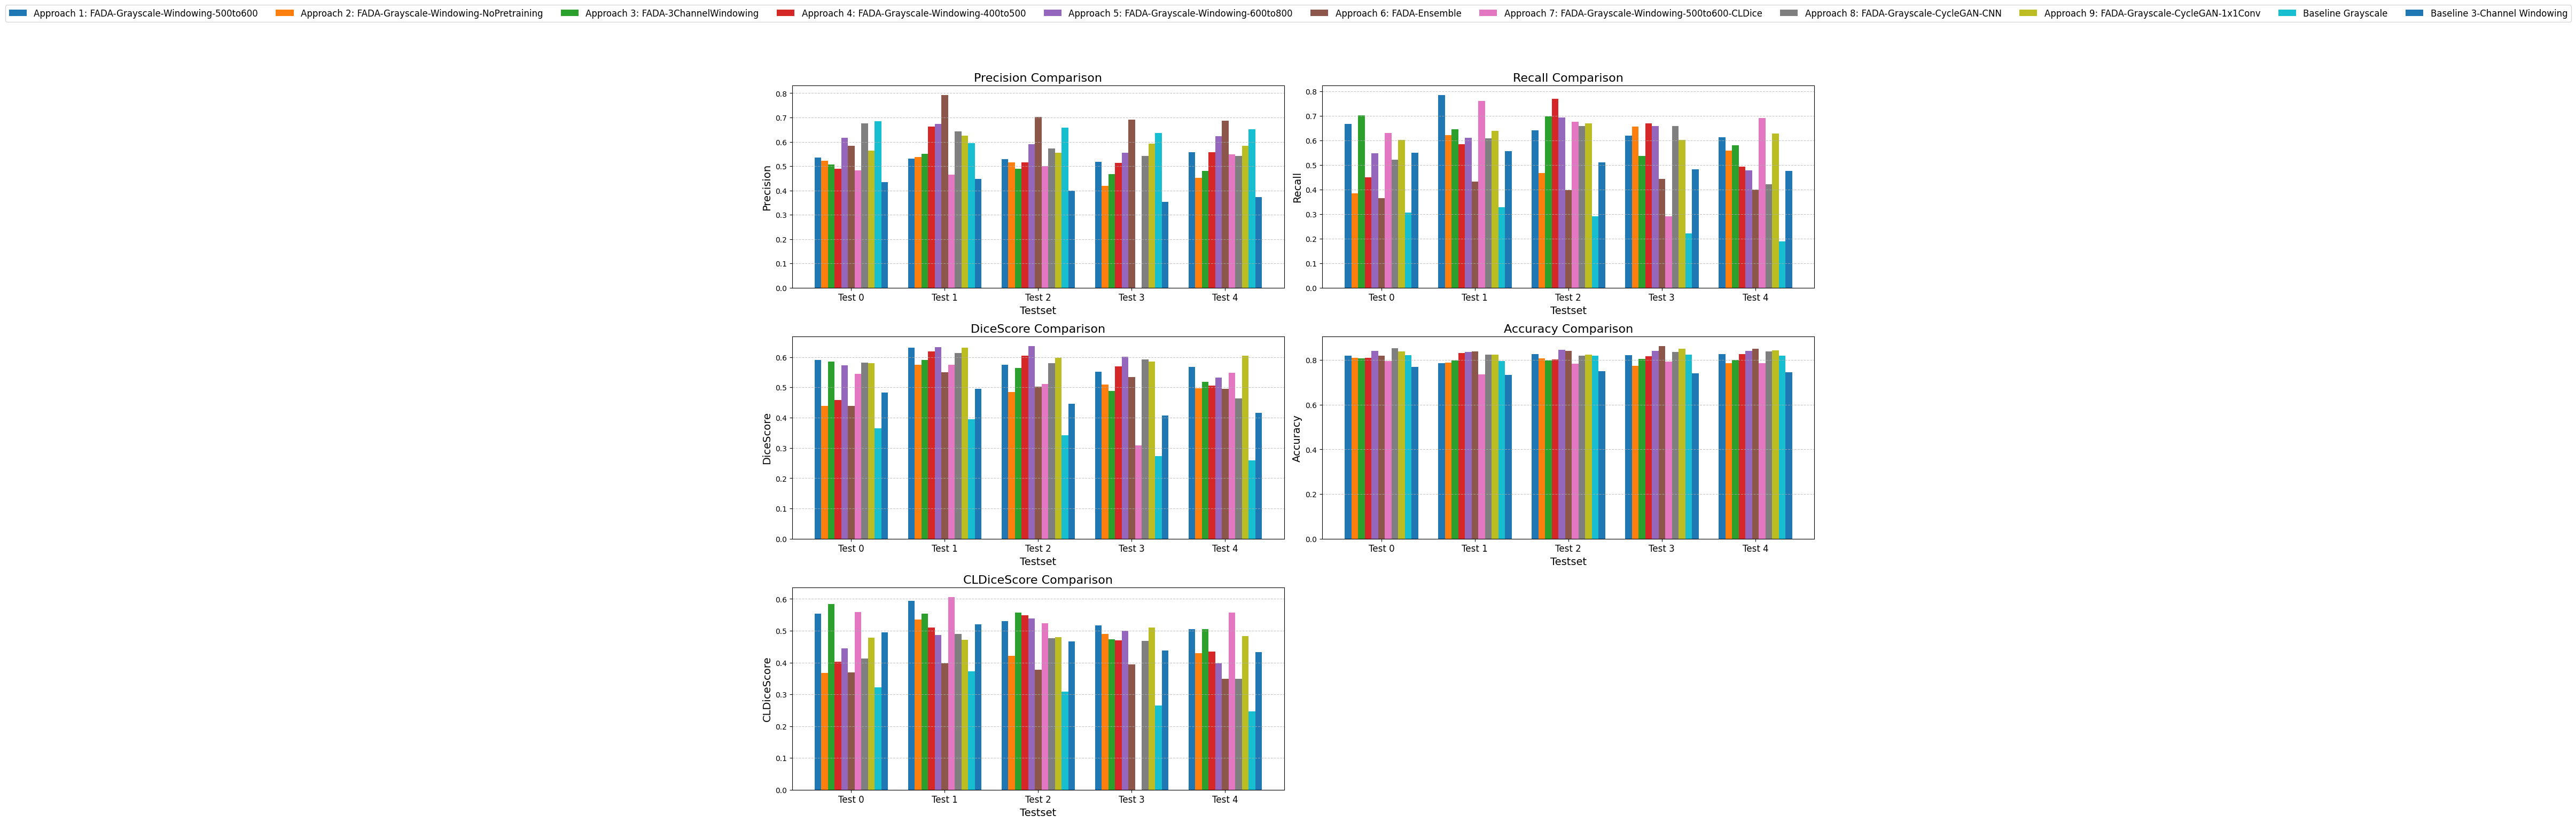

In [12]:
import matplotlib.pyplot as plt
import numpy as np
approach1 = {
    0: {"Precision": 0.5352, "Recall": 0.6670, "DiceScore": 0.5910, "Accuracy": 0.8196, "CLDiceScore": 0.5533},
    1: {"Precision": 0.5303, "Recall": 0.7830, "DiceScore": 0.6316, "Accuracy": 0.7854, "CLDiceScore": 0.5946},
    2: {"Precision": 0.5292, "Recall": 0.6412, "DiceScore": 0.5739, "Accuracy": 0.8251, "CLDiceScore": 0.5309},
    3: {"Precision": 0.5170, "Recall": 0.6194, "DiceScore": 0.5522, "Accuracy": 0.8223, "CLDiceScore": 0.5161},
    4: {"Precision": 0.5572, "Recall": 0.6122, "DiceScore": 0.5679, "Accuracy": 0.8267, "CLDiceScore": 0.5054},
}

approach2 = {
    0: {"Precision": 0.5215, "Recall": 0.3836, "DiceScore": 0.4391, "Accuracy": 0.8105, "CLDiceScore": 0.3675},
    1: {"Precision": 0.5370, "Recall": 0.6201, "DiceScore": 0.5739, "Accuracy": 0.7871, "CLDiceScore": 0.5359},
    2: {"Precision": 0.5145, "Recall": 0.4671, "DiceScore": 0.4838, "Accuracy": 0.8076, "CLDiceScore": 0.4206},
    3: {"Precision": 0.4186, "Recall": 0.6554, "DiceScore": 0.5100, "Accuracy": 0.7725, "CLDiceScore": 0.4902},
    4: {"Precision": 0.4513, "Recall": 0.5585, "DiceScore": 0.4962, "Accuracy": 0.7865, "CLDiceScore": 0.4297},
}

approach3 = {
    0: {"Precision": 0.5057, "Recall": 0.7008, "DiceScore": 0.5851, "Accuracy": 0.8076, "CLDiceScore": 0.5838},
    1: {"Precision": 0.5496, "Recall": 0.6445, "DiceScore": 0.5901, "Accuracy": 0.7969, "CLDiceScore": 0.5533},
    2: {"Precision": 0.4882, "Recall": 0.6959, "DiceScore": 0.5640, "Accuracy": 0.7975, "CLDiceScore": 0.5577},
    3: {"Precision": 0.4675, "Recall": 0.5350, "DiceScore": 0.4882, "Accuracy": 0.8040, "CLDiceScore": 0.4738},
    4: {"Precision": 0.4793, "Recall": 0.5797, "DiceScore": 0.5174, "Accuracy": 0.8007, "CLDiceScore": 0.5042},
}

approach4 = {
    0: {"Precision": 0.4900, "Recall": 0.4502, "DiceScore": 0.4587, "Accuracy": 0.8090, "CLDiceScore": 0.4030},
    1: {"Precision": 0.6636, "Recall": 0.5839, "DiceScore": 0.6185, "Accuracy": 0.8303, "CLDiceScore": 0.5100},
    2: {"Precision": 0.5159, "Recall": 0.7684, "DiceScore": 0.6044, "Accuracy": 0.8017, "CLDiceScore": 0.5479},
    3: {"Precision": 0.5130, "Recall": 0.6696, "DiceScore": 0.5690, "Accuracy": 0.8173, "CLDiceScore": 0.4701},
    4: {"Precision": 0.5580, "Recall": 0.4937, "DiceScore": 0.5058, "Accuracy": 0.8265, "CLDiceScore": 0.4351},
}

approach5 = {
    0: {"Precision": 0.6166, "Recall": 0.5479, "DiceScore": 0.5725, "Accuracy": 0.8410, "CLDiceScore": 0.4437},
    1: {"Precision": 0.6738, "Recall": 0.6101, "DiceScore": 0.6325, "Accuracy": 0.8346, "CLDiceScore": 0.4865},
    2: {"Precision": 0.5898, "Recall": 0.6921, "DiceScore": 0.6357, "Accuracy": 0.8463, "CLDiceScore": 0.5393},
    3: {"Precision": 0.5557, "Recall": 0.6573, "DiceScore": 0.6011, "Accuracy": 0.8414, "CLDiceScore": 0.4991},
    4: {"Precision": 0.6222, "Recall": 0.4784, "DiceScore": 0.5318, "Accuracy": 0.8394, "CLDiceScore": 0.3968},
}


approach6 = {
    0: {"Precision": 0.5827, "Recall": 0.3645, "DiceScore": 0.4380, "Accuracy": 0.8192, "CLDiceScore": 0.3688},
    1: {"Precision": 0.7914, "Recall": 0.4309, "DiceScore": 0.5500, "Accuracy": 0.8380, "CLDiceScore": 0.3970},
    2: {"Precision": 0.7020, "Recall": 0.3966, "DiceScore": 0.5029, "Accuracy": 0.8408, "CLDiceScore": 0.3776},
    3: {"Precision": 0.6902, "Recall": 0.4428, "DiceScore": 0.5340, "Accuracy": 0.8612, "CLDiceScore": 0.3941},
    4: {"Precision": 0.6864, "Recall": 0.3987, "DiceScore": 0.4959, "Accuracy": 0.8489, "CLDiceScore": 0.3489},
}

approach7= {
    0: {"Precision": 0.4815, "Recall": 0.6294, "DiceScore": 0.5438, "Accuracy": 0.7948, "CLDiceScore": 0.5585},
    1: {"Precision": 0.4655, "Recall": 0.7588, "DiceScore": 0.5746, "Accuracy": 0.7363, "CLDiceScore": 0.6051},
    2: {"Precision": 0.4996, "Recall": 0.6755, "DiceScore": 0.5114, "Accuracy": 0.7841, "CLDiceScore": 0.5233},
    3: {"Precision": 0.0, "Recall": 0.2905, "DiceScore": 0.3079, "Accuracy": 0.7928, "CLDiceScore": 0.0},
    4: {"Precision": 0.5480, "Recall": 0.6907, "DiceScore": 0.5480, "Accuracy": 0.7845, "CLDiceScore": 0.5571},
}

approach8 = {
    0: {"Precision": 0.6755, "Recall": 0.5216, "DiceScore": 0.5808, "Accuracy": 0.8527, "CLDiceScore": 0.4120},
    1: {"Precision": 0.6439, "Recall": 0.6085, "DiceScore": 0.6142, "Accuracy": 0.8228, "CLDiceScore": 0.4890},
    2: {"Precision": 0.5723, "Recall": 0.6578, "DiceScore": 0.5804, "Accuracy": 0.8194, "CLDiceScore": 0.4759},
    3: {"Precision": 0.5422, "Recall": 0.6585, "DiceScore": 0.5917, "Accuracy": 0.8363, "CLDiceScore": 0.4686},
    4: {"Precision": 0.5429, "Recall": 0.4202, "DiceScore": 0.4642, "Accuracy": 0.8377, "CLDiceScore": 0.3487},
}

approach9= {
    0: {"Precision": 0.5648, "Recall": 0.6010, "DiceScore": 0.5806, "Accuracy": 0.8374, "CLDiceScore": 0.4786},
    1: {"Precision": 0.6256, "Recall": 0.6391, "DiceScore": 0.6308, "Accuracy": 0.8244, "CLDiceScore": 0.4719},
    2: {"Precision": 0.5543, "Recall": 0.6682, "DiceScore": 0.5980, "Accuracy": 0.8246, "CLDiceScore": 0.4805},
    3: {"Precision": 0.5913, "Recall": 0.6008, "DiceScore": 0.5859, "Accuracy": 0.8503, "CLDiceScore": 0.5102},
    4: {"Precision": 0.5845, "Recall": 0.6272, "DiceScore": 0.6040, "Accuracy": 0.8437, "CLDiceScore": 0.4825},
}

baseline_grayscale = {
    0: {"Precision": 0.6847, "Recall": 0.3061, "DiceScore": 0.3642, "Accuracy": 0.8222, "CLDiceScore": 0.3211},
    1: {"Precision": 0.5940, "Recall": 0.3265, "DiceScore": 0.3955, "Accuracy": 0.7941, "CLDiceScore": 0.3715},
    2: {"Precision": 0.6585, "Recall": 0.2905, "DiceScore": 0.3422, "Accuracy": 0.8192, "CLDiceScore": 0.3084},
    3: {"Precision": 0.6354, "Recall": 0.2208, "DiceScore": 0.2730, "Accuracy": 0.8240, "CLDiceScore": 0.2654},
    4: {"Precision": 0.6506, "Recall": 0.1889, "DiceScore": 0.2589, "Accuracy": 0.8196, "CLDiceScore": 0.2459},
}

baseline_3ChannelWindowing = {
    0: {"Precision": 0.4339, "Recall": 0.5488, "DiceScore": 0.4825, "Accuracy": 0.7693, "CLDiceScore": 0.4957},
    1: {"Precision": 0.4479, "Recall": 0.5558, "DiceScore": 0.4948, "Accuracy": 0.7320, "CLDiceScore": 0.5193},
    2: {"Precision": 0.3999, "Recall": 0.5096, "DiceScore": 0.4459, "Accuracy": 0.7490, "CLDiceScore": 0.4655},
    3: {"Precision": 0.3523, "Recall": 0.4823, "DiceScore": 0.4065, "Accuracy": 0.7404, "CLDiceScore": 0.4379},
    4: {"Precision": 0.3720, "Recall": 0.4754, "DiceScore": 0.4152, "Accuracy": 0.7452, "CLDiceScore": 0.4331},
}

approaches = {
    "Approach 1: FADA-Grayscale-Windowing-500to600": approach1,
    "Approach 2: FADA-Grayscale-Windowing-NoPretraining": approach2,
    "Approach 3: FADA-3ChannelWindowing": approach3,
    "Approach 4: FADA-Grayscale-Windowing-400to500": approach4,
    "Approach 5: FADA-Grayscale-Windowing-600to800": approach5,
    "Approach 6: FADA-Ensemble": approach6,
    "Approach 7: FADA-Grayscale-Windowing-500to600-CLDice": approach7,
    "Approach 8: FADA-Grayscale-CycleGAN-CNN": approach8,
    "Approach 9: FADA-Grayscale-CycleGAN-1x1Conv": approach9,
    "Baseline Grayscale": baseline_grayscale,
    "Baseline 3-Channel Windowing": baseline_3ChannelWindowing,
}

metrics = ["Precision", "Recall", "DiceScore", "Accuracy", "CLDiceScore"]
images = range(5)

# Plot settings
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()
handles, labels = [], []

gap = 0.3        # Extra gap between groups
width = 0.1      # Bar width
num_approaches = len(approaches)
group_width = width * num_approaches + gap  # Total width for each group of bars

for i, metric in enumerate(metrics):
    ax = axes[i]
    # Multiply the image index by group_width to add space between groups
    x = np.arange(len(images)) * group_width

    for j, (approach_name, approach_data) in enumerate(approaches.items()):
        values = [approach_data[img][metric] for img in images]
        bars = ax.bar(x + j * width, values, width, label=approach_name)

        if i == 0:  # Only add labels once for the legend
            handles.append(bars[0])
            labels.append(approach_name)

    ax.set_title(f"{metric} Comparison", fontsize=16)
    # Center the xticks within each group
    ax.set_xticks(x + width * (num_approaches - 1) / 2)
    ax.set_xticklabels([f"Test {img}" for img in images], fontsize=12)
    ax.set_xlabel("Testset", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Hide any unused subplot (the 6th axis in this case)
for i in range(len(metrics), len(axes)):
    axes[i].axis("off")

fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=num_approaches,
    fontsize=12,
    bbox_to_anchor=(0.5, 1.03),
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

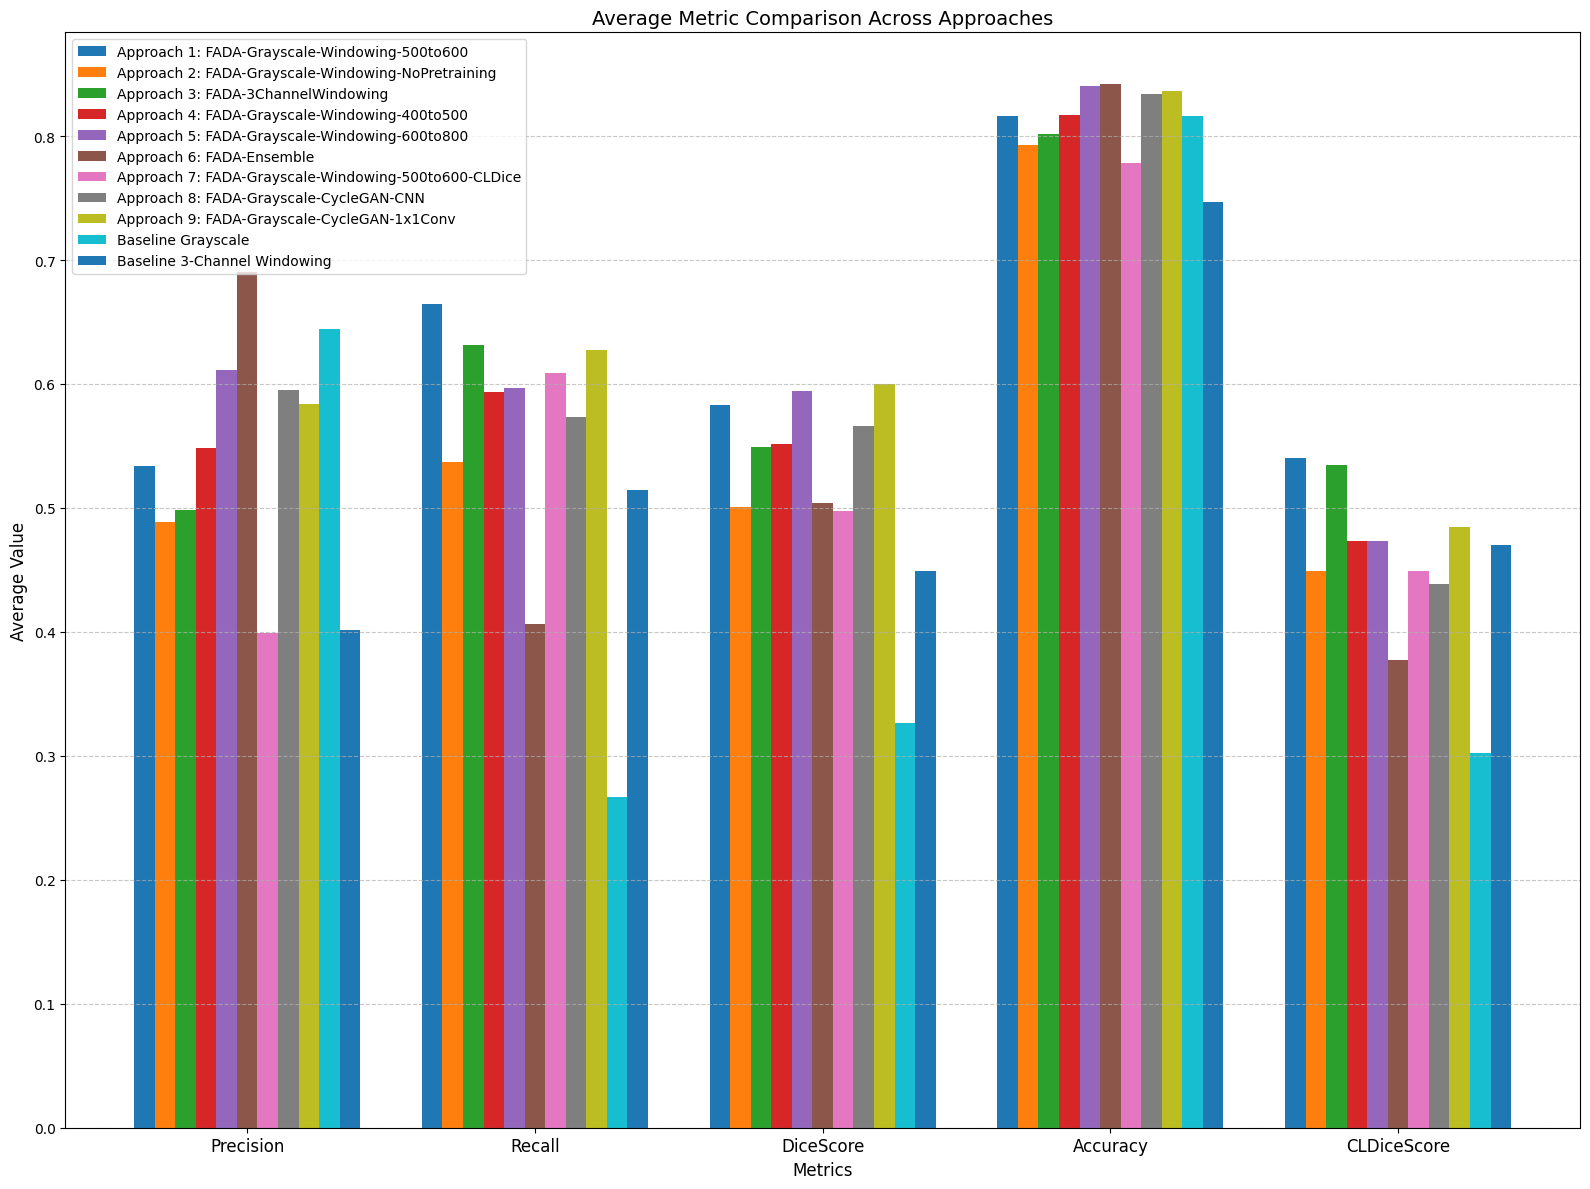

In [15]:
average_metrics = {approach_name: {metric: np.mean([data[image][metric] for image in images])
                                   for metric in metrics}
                   for approach_name, data in approaches.items()}

gap = 0.3        # Extra gap between metric groups
width = 0.1      # Bar width
num_approaches = len(approaches)
group_width = width * num_approaches + gap  # Total width for each metric group

# Scale the x-axis positions by the group width to add extra space between groups
x = np.arange(len(metrics)) * group_width  

fig, ax = plt.subplots(figsize=(16, 12))

for i, (approach_name, metrics_data) in enumerate(average_metrics.items()):
    values = [metrics_data[metric] for metric in metrics]
    ax.bar(x + i * width, values, width, label=approach_name)

ax.set_title("Average Metric Comparison Across Approaches", fontsize=14)
# Center the xticks within each metric group
ax.set_xticks(x + width * (num_approaches - 1) / 2)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Average Value", fontsize=12)
ax.legend(fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np
from IPython.display import display

# # Data
# approach1 = {
#     0: {"Precision": 0.5352, "Recall": 0.6670, "DiceScore": 0.5910, "Accuracy": 0.8196},
#     1: {"Precision": 0.5303, "Recall": 0.7830, "DiceScore": 0.6316, "Accuracy": 0.7854},
#     2: {"Precision": 0.5292, "Recall": 0.6412, "DiceScore": 0.5739, "Accuracy": 0.8251},
#     3: {"Precision": 0.5170, "Recall": 0.6194, "DiceScore": 0.5522, "Accuracy": 0.8223},
#     4: {"Precision": 0.5572, "Recall": 0.6122, "DiceScore": 0.5679, "Accuracy": 0.8267},
# }

# approach2 = {
#     0: {"Precision": 0.5215, "Recall": 0.3836, "DiceScore": 0.4391, "Accuracy": 0.8105},
#     1: {"Precision": 0.5370, "Recall": 0.6201, "DiceScore": 0.5739, "Accuracy": 0.7871},
#     2: {"Precision": 0.5145, "Recall": 0.4671, "DiceScore": 0.4838, "Accuracy": 0.8076},
#     3: {"Precision": 0.4186, "Recall": 0.6554, "DiceScore": 0.5100, "Accuracy": 0.7725},
#     4: {"Precision": 0.4513, "Recall": 0.5585, "DiceScore": 0.4962, "Accuracy": 0.7865},
# }

# approach3 = {
#     0: {"Precision": 0.5057, "Recall": 0.7008, "DiceScore": 0.5851, "Accuracy": 0.8076},
#     1: {"Precision": 0.5496, "Recall": 0.6445, "DiceScore": 0.5901, "Accuracy": 0.7969},
#     2: {"Precision": 0.4882, "Recall": 0.6959, "DiceScore": 0.5640, "Accuracy": 0.7975},
#     3: {"Precision": 0.4675, "Recall": 0.5350, "DiceScore": 0.4882, "Accuracy": 0.8040},
#     4: {"Precision": 0.4793, "Recall": 0.5797, "DiceScore": 0.5174, "Accuracy": 0.8007},
# }

# baseline_grayscale = {
#     0: {"Precision": 0.6847, "Recall": 0.3061, "DiceScore": 0.3642, "Accuracy": 0.8222},
#     1: {"Precision": 0.5940, "Recall": 0.3265, "DiceScore": 0.3955, "Accuracy": 0.7941},
#     2: {"Precision": 0.6585, "Recall": 0.2905, "DiceScore": 0.3422, "Accuracy": 0.8192},
#     3: {"Precision": 0.6354, "Recall": 0.2208, "DiceScore": 0.2730, "Accuracy": 0.8240},
#     4: {"Precision": 0.6506, "Recall": 0.1889, "DiceScore": 0.2589, "Accuracy": 0.8196},
# }

# baseline_3ChannelWindowing = {
#     0: {"Precision": 0.4339, "Recall": 0.5488, "DiceScore": 0.4825, "Accuracy": 0.7693},
#     1: {"Precision": 0.4479, "Recall": 0.5558, "DiceScore": 0.4948, "Accuracy": 0.7320},
#     2: {"Precision": 0.3999, "Recall": 0.5096, "DiceScore": 0.4459, "Accuracy": 0.7490},
#     3: {"Precision": 0.3523, "Recall": 0.4823, "DiceScore": 0.4065, "Accuracy": 0.7404},
#     4: {"Precision": 0.3720, "Recall": 0.4754, "DiceScore": 0.4152, "Accuracy": 0.7452},
# }

# approaches = {
#     "Approach 1: FADA-Grayscale-Windowing:": approach1,
#     "Approach 2: FADA-Grayscale-Windowing-NoPretraining": approach2,
#     "Approach 3: FADA-3ChannelWindowing": approach3,
#     "Baseline Grayscale": baseline_grayscale,
#     "Baseline 3-Channel Windowing": baseline_3ChannelWindowing,
# }

metrics = ["Precision", "Recall", "DiceScore", "Accuracy", "CLDiceScore"]
images = range(5)

# Prepare data for the DiceScore table with approaches as rows
dice_scores = []

# Extract DiceScores for each approach and image
for approach_name, data in approaches.items():
    row = {"Approach": approach_name}
    for image in images:
        test_indices = set(images) - {image}
        row[f"{test_indices}"] = round(data[image]["CLDiceScore"], 4)
    # Add the average DiceScore for the approach
    row["Averaged"] = round(np.mean([data[image]["CLDiceScore"] for image in images]), 4)
    dice_scores.append(row)

# Convert to DataFrame
dice_df_transposed = pd.DataFrame(dice_scores)

dice_df_transposed.head(n=11)

,Approach,"{1, 2, 3, 4}","{0, 2, 3, 4}","{0, 1, 3, 4}","{0, 1, 2, 4}","{0, 1, 2, 3}",Averaged
0,Approach 1: FADA-Grayscale-Windowing-500to600,0.5533,0.5946,0.5309,0.5161,0.5054,0.5401
1,Approach 2: FADA-Grayscale-Windowing-NoPretrai...,0.3675,0.5359,0.4206,0.4902,0.4297,0.4488
2,Approach 3: FADA-3ChannelWindowing,0.5838,0.5533,0.5577,0.4738,0.5042,0.5346
3,Approach 4: FADA-Grayscale-Windowing-400to500,0.4030,0.5100,0.5479,0.4701,0.4351,0.4732
4,Approach 5: FADA-Grayscale-Windowing-600to800,0.4437,0.4865,0.5393,0.4991,0.3968,0.4731
5,Approach 6: FADA-Ensemble,0.3688,0.3970,0.3776,0.3941,0.3489,0.3773
6,Approach 7: FADA-Grayscale-Windowing-500to600-...,0.5585,0.6051,0.5233,0.0000,0.5571,0.4488
7,Approach 8: FADA-Grayscale-CycleGAN-CNN,0.4120,0.4890,0.4759,0.4686,0.3487,0.4388
8,Approach 9: FADA-Grayscale-CycleGAN-1x1Conv,0.4786,0.4719,0.4805,0.5102,0.4825,0.4847
9,Baseline Grayscale,0.3211,0.3715,0.3084,0.2654,0.2459,0.3025
